# Classifying Chest Pain

>## Authors: Derek, Eric, & Selina

### Introduction

Heart disease include several types of heart conditions which affect the heart. 1 in 12 Canadian above age 20 live with heart disease (Canadian Chronic Disease Surveillance System (CCDSS), 2017). There are many reasons that cause heart diseases such as high blood pressure, high blood cholesterol, and other behaviours that are harmful to our bodies. Common symptoms of heart disease is chest pain. Heart-related chest pain is pressure or tightness generally caused by reduced blood flow to the heart. Our project focuses on factors that lead to chest pain. The four chest pains are classifed as, typical angina, atypical angina, non-anginal pain, and asymptomatic chest pain. The predictive question of classification we will answer is whether maximum heart rate achieved(thalach) and resting blood pressure(trestbps) can be used to predict what type of cp an individual will have. We downloaded the dataset from the UC Irvine Machine Learning Repository on heart disease (UCI Machine Learning Repository: Heart Disease Data Set, 1988).

### About the Dataset
This entire database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. Here are the 14 columns used:

1. Age (in years)
2. Sex
    - 1 = male
    - 2 = female
3. Chest Pain Type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. Resting Blood Pressure (in mmHg)
5. Cholesterol (serum cholesterol in mg/dl)
6. Fasting Blood Sugar (> 120 mg/dl)
    - 0 = false
    - 1 = true
7. Resting Electrocardiographic Results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. Maximum Heart Rate Achieved (beats per minute)
9. Exercise Induced Angina
    - 1 = yes
    - 0 = no
10. ST depression induced by exercise relative to rest
11. The Slope of the Peak Exercise ST Segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. Number of Major Vessels Coloured by Flourosopy
13. Thalassemia
    - Value 3: normal
    - Value 6: fixed defect
    - Value 7: reversable defect
14. Diagnosis of Heart Disease
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing

### Reading, Cleaning, and Wrangling the Dataset

In [68]:
#Install the packages for using the function step_upsample
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [69]:
library(dplyr)
library(readxl)
library(tidyverse)
library(themis)
library(GGally)

In [77]:
# Loading the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_data <- read_csv(url, col_names = FALSE, na = c("?")) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    mutate(cp = as_factor(cp)) |>
    drop_na(trestbps) |>
    drop_na(thalach) |>
    filter(trestbps != 0) |>
    filter(thalach != 0)
# Only showing the first five rows
head(heart_disease_data, n = 5)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


### Selecting Only the Columns Used

In [78]:
heart_disease_dataset <- heart_disease_data |>
select(cp, trestbps, thalach)

In [79]:
head(heart_disease_dataset, n = 5)

cp,trestbps,thalach
<fct>,<dbl>,<dbl>
1,145,150
4,160,108
4,120,129
3,130,187
2,130,172


### Splitting the Testing and Training Dataset

In [80]:
set.seed(1)
library(tidymodels)

heart_disease_split <- initial_split(heart_disease_dataset, prop = 0.75, strata = cp)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

### Summarizing & Reporting the Number of Observations and Percentages in Each Class in the Training Set

In [81]:
heart_disease_observations <- heart_disease_train |>
                      group_by(cp) |>
                      summarize(n = n()) |>
                      mutate(percent = 100 * n / nrow(heart_disease_train))

In [82]:
heart_disease_observations

cp,n,percent
<fct>,<int>,<dbl>
1,18,7.964602
2,38,16.814159
3,64,28.318584
4,106,46.902655


### Summarize the means of the predictor variables & shows how many rows have missing data

In [83]:
heart_disease_exploratory <- read_csv(url, col_names = FALSE, na = c("?")) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    mutate(cp = as_factor(cp))
#finding the number of na's in trestbps and % of na's in original dataset
trestbps_na <- heart_disease_exploratory |> 
                      filter(is.na(trestbps)) |>
                      summarize(trestbps_na = n()) |>
                      mutate(percent = 100 * trestbps_na / nrow(heart_disease_exploratory))
#finding the number of na's in thalach and % of na's in original dataset
thalach_na <- heart_disease_exploratory |> 
                      filter(is.na(thalach)) |>
                      summarize(thalach_na = n()) |>
                      mutate(percent = 100 * thalach_na / nrow(heart_disease_exploratory))
# finding the mean of predictors
predictor_means <- heart_disease_train |>
                      summarize(mean_trestbps = mean(trestbps, na.rm = TRUE), mean_thalach = mean(thalach, na.rm = TRUE))
#Print the recipe
heart_recipe <- recipe(cp ~ trestbps + thalach, data = heart_disease_train, skip = FALSE)|>
                        prep() 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [84]:
trestbps_na 
thalach_na
predictor_means
heart_recipe 

trestbps_na,percent
<int>,<dbl>
0,0


thalach_na,percent
<int>,<dbl>
0,0


mean_trestbps,mean_thalach
<dbl>,<dbl>
131.8584,149.1106


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 226 data points and no missing data.

###  Data Visualization

In [85]:
options(repr.plot.width = 10, repr.plot.height = 7)

# histogram for resting blood pressure observations
trestbps_hist <- ggplot(heart_disease_train, aes(x = trestbps)) + 
    geom_histogram(bins = 25) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Observations") +
    ggtitle("Number of Observations of Resting Blood Pressure (mmHg) in Training Dataset") +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_y_continuous(breaks = pretty_breaks())
# histogram for maximum heart rate observations
thalach_hist <- ggplot(heart_disease_train, aes(x = thalach)) + 
    geom_histogram(bins = 25) +
    labs(x = "Maximum Heart Rate (beats per minute)", y = "Number of Observations") +
    ggtitle("Number of Observations of Max Heart Rate in Training Dataset") +
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(breaks = pretty_breaks())
# visualizing the plot for knn
heart_plot <- heart_disease_train |> 
    ggplot(aes(x = trestbps, y = thalach, color = cp)) +
    geom_point(alpha = 0.5) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Maximum Heart Rate (beats per minute)", color = "Chest Pain Types") + 
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina","Non-Anginal Pain","Asymptomatic"), 
                     values = c("orange2", "steelblue2","purple2", "green2")) + 
    theme(text = element_text(size = 12)) +
    ggtitle("Max Heart Rate vs Resting Blood Pressure") + 
    theme(plot.title = element_text(hjust = 0.5))

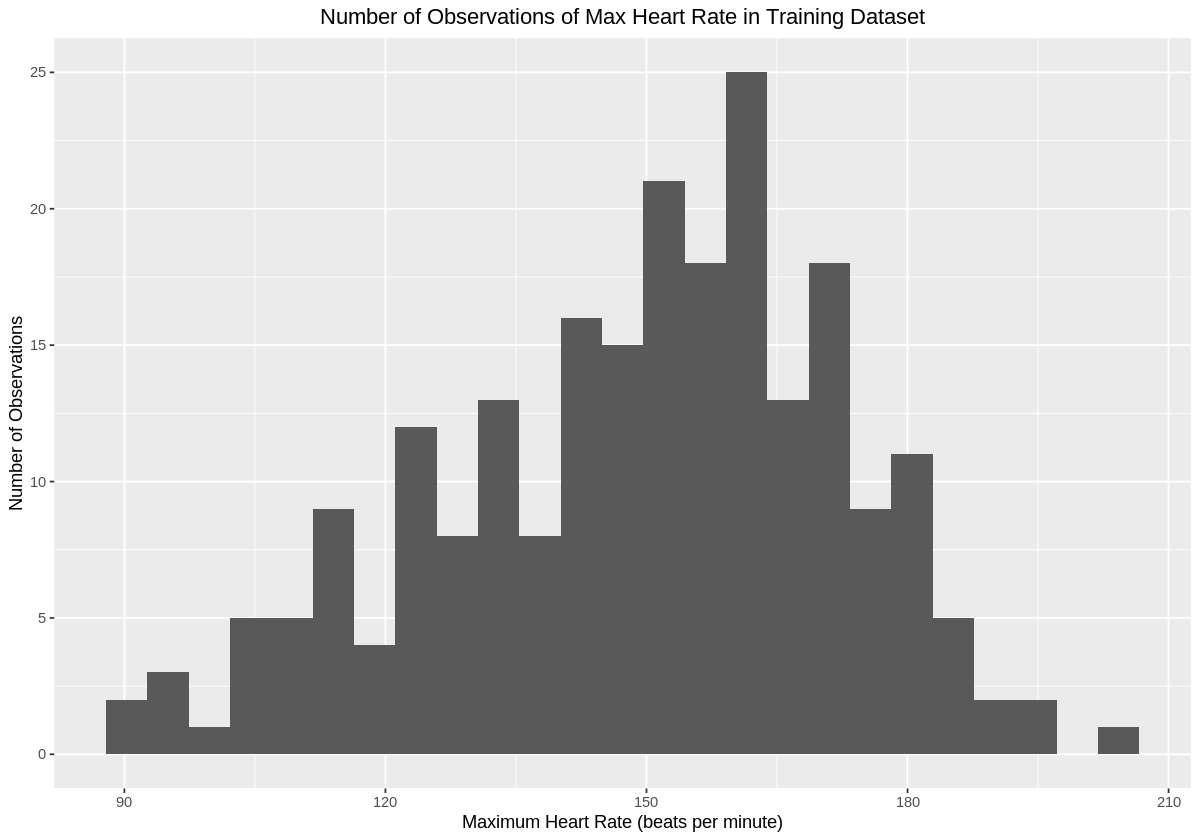

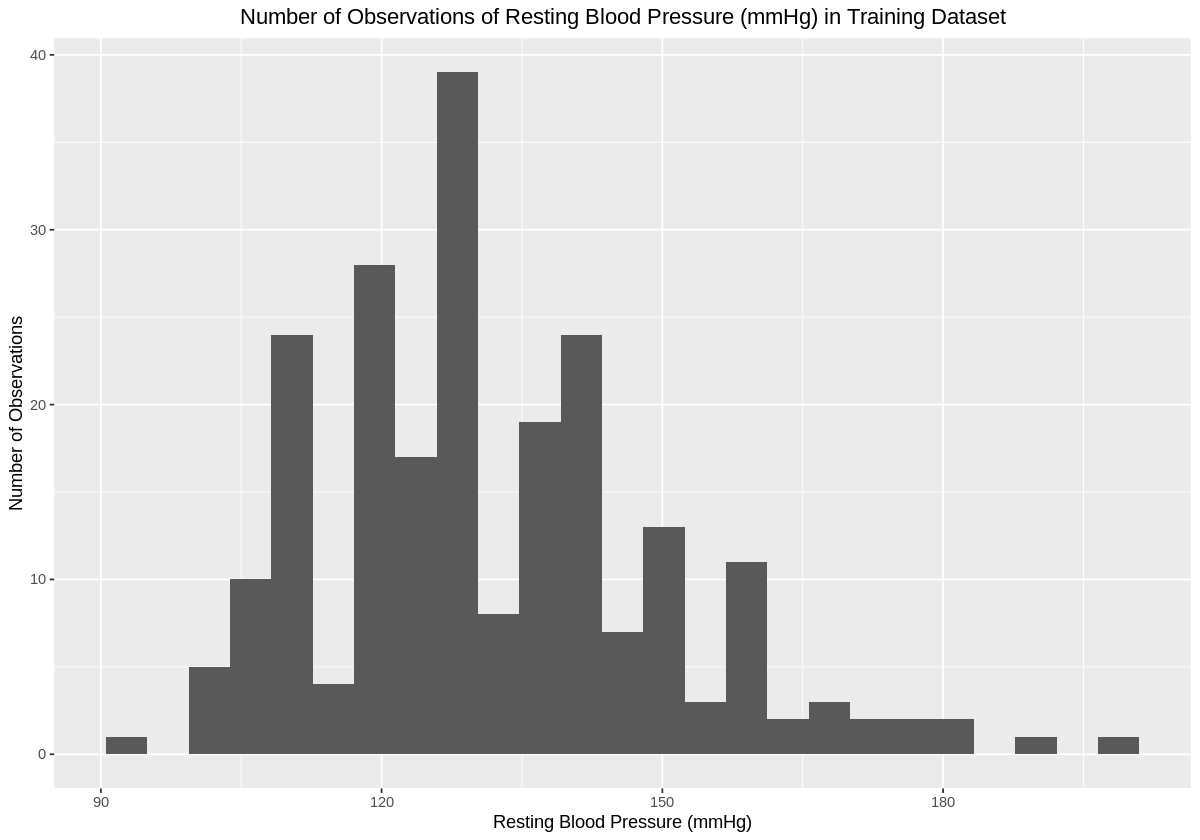

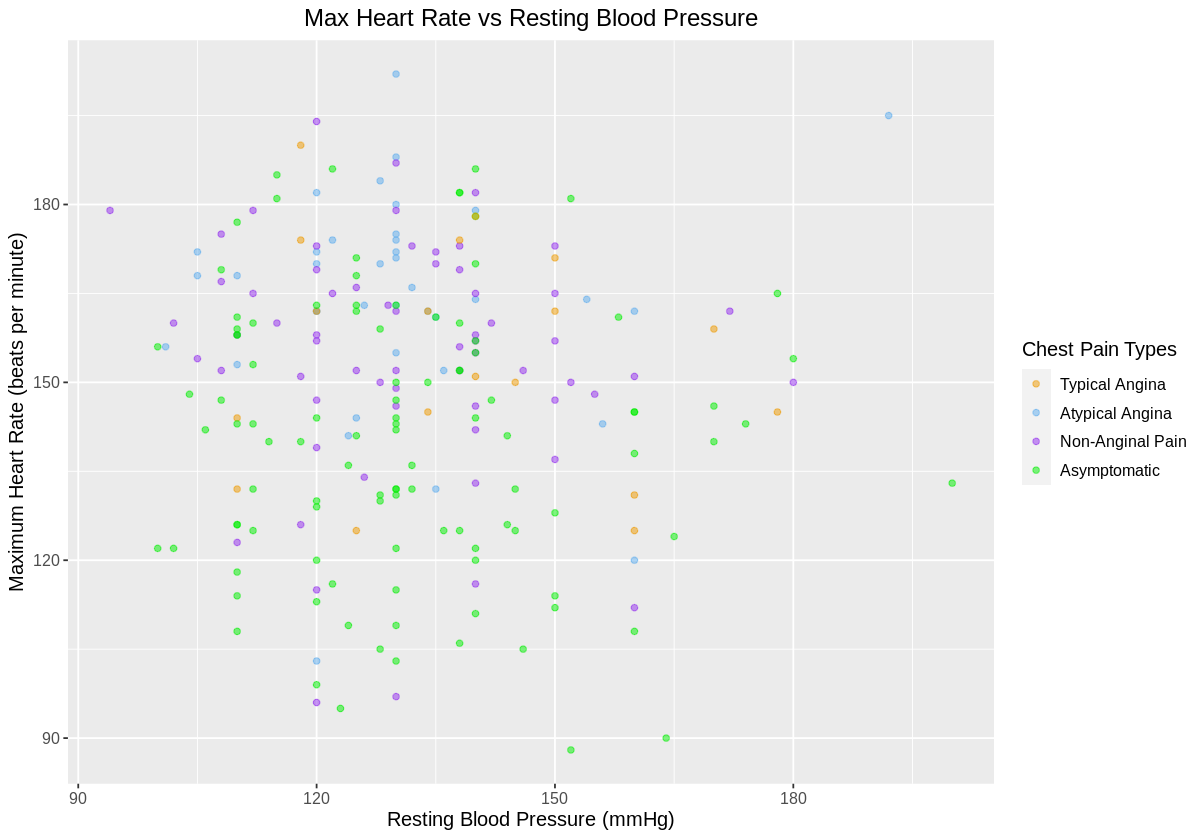

In [86]:
thalach_hist
trestbps_hist
heart_plot

### Methods

We use the maximum achieved heart rate and resting blood pressure columns as predictors because these variables are the most commonly associated measures for chest pain. We are trying to predict the type of chest pain a person has, so the chest pain column will be our class/factor. The relationship between data points is presented in scatter plot format. With resting blood pressure on the x axis and maximum heart rate on the y axis, class represented by colour/shape. The last representative is for the final outcome. We will use k-nearest predictor with rectangular weighted function and knn classification method. We will also use folding and multi-sampling to guarantee the accurcy of our algirthom. 

### Expected outcomes and significance

In this project, we will create classifiers that, given a testing set with the predictors of resting blood pressure and maximum achieved heart rate, can predict chest pain type with adequate accuracy. In this process, we also expect to determine whether or not high blood pressure and serum cholesterol have a connection to different types of chest pain.

If we predict which cp type an individual will have based on rbp and serum cholesterol, we could recommend treatment and lifestyle changes corresponding to their cp type before conditions worsens. The four chespains are associated with different severities and treatments. The sooner these cp type are detected and treated, the less risk of patient developing heart disease.

Another question our data analysis lead to is treatment or medication for different types of heart disease. If we predict which cp type someone is susceptible to, then we can analyze how different medications, exercise habits, or changing their diet improve their health could prove beneficial at creating better treatment to heart disease across the world, using data collected relating the health of the individual.

### Building our classifier

In [87]:
set.seed(1)
# Creating our recipe and scaling, centering, and balancing our predictors
heart_disease_recipe <- recipe(cp ~ thalach + trestbps, data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(cp, over_ratio = 1)

In [88]:
heart_disease_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()
Up-sampling based on cp

In [89]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

In [90]:
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [91]:
set.seed(1)
#Perform 5-fold cross-validation to choose best k
hd_vfold <- vfold_cv(heart_disease_train, v = 5, strata = cp)
gridvals <- tibble(neighbors = seq(1, 75))

hd_results <- workflow() |> 
    add_recipe(heart_disease_recipe) |> 
    add_model(knn_spec)|> 
    tune_grid(resamples = hd_vfold, grid = gridvals) |> 
    collect_metrics() |>
    filter(.metric == "accuracy")

best_estimated_accuracy <- hd_results |> 
    select(neighbors,.metric,mean)|>
    arrange(desc(mean))|>
    head(5)
best_estimated_accuracy

neighbors,.metric,mean
<int>,<chr>,<dbl>
71,accuracy,0.4155233
63,accuracy,0.4153342
70,accuracy,0.4111670
65,accuracy,0.4108897
68,accuracy,0.4108897


In [92]:
Best_k<- best_estimated_accuracy|>
    select(neighbors:mean)|>
    summarise(max(mean))|>
    pull()
Best_k

[1] 0.4155233

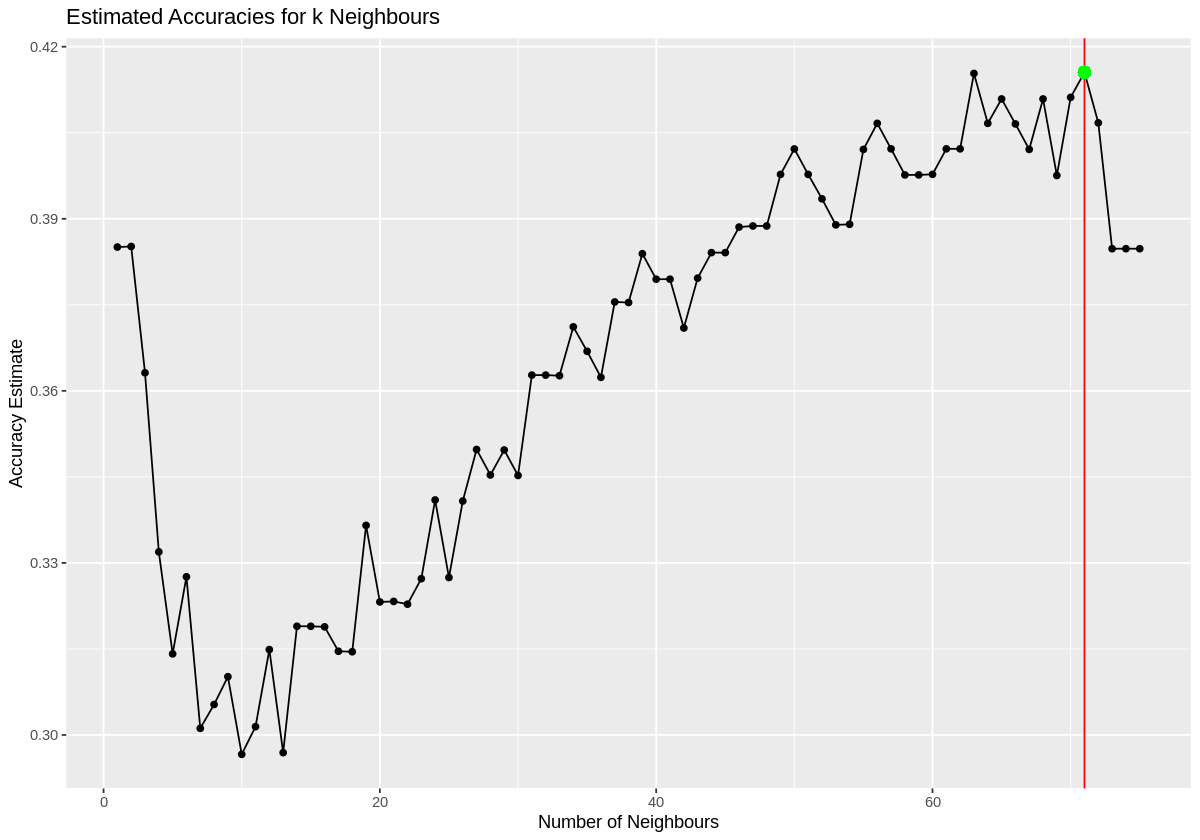

In [93]:
# plot out and look at which value of k is the best 

# cross_val_plot <- hd_results |> # commented this out for now
#     ggplot(aes(x = neighbors, y = mean)) +
#     geom_point() +
#     geom_line() +
#     labs(x = "K value", y = "Accuracy Estimate", title = "Estimated Accuracies for k Neighbours") +
#     scale_x_continuous(limits = c(1, 50)) +
#     theme(text = element_text(size = 14))

cross_val_plot <- hd_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 71, colour = "red") +
    geom_point(aes(x = 71, y = Best_k), size = 3, colour = "green") +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate", title = "Estimated Accuracies for k Neighbours")
cross_val_plot  

### KNN Classification

In [94]:
set.seed(1)
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 71) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

heart_disease_fit <- workflow() %>%
  add_recipe(heart_disease_recipe) %>%
  add_model(knn_best_spec) %>%
  fit(data = heart_disease_train)

heart_disease_predictions <- predict(heart_disease_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_disease_accuracy <- heart_disease_predictions %>% 
    metrics(truth = cp, estimate = .pred_class) %>% 
    select(.metric, .estimate) %>% 
    head(1)
heart_disease_accuracy

.metric,.estimate
<chr>,<dbl>
accuracy,0.3376623


### add a confusion matrix here???

### Discussion

## Citations

   
Canadian Chronic Disease Surveillance System (CCDSS). (2017). https://health-infobase.canada.ca/ccdss/data-tool/Index?G=00 

UCI Machine Learning Repository: Heart Disease Data Set. (1988). https://archive.ics.uci.edu/ml/datasets/Heart+Disease